### This is a common homework assignment for both frameworks

This week's assignment appears to be unusually grandeur, so please read submission/grading guidelines before you upload it for review.

__Submisson__: To ease mutual pain, please submit
- Some kind of readable report with links to your evaluations, gym uploads, investigation results, etc.
- Explicitly state that you took on a bonus task and where to find it [to make sure it is found and graded].

__Grading__: The main purpose (and source of points) for this notebook is your investigation, not squeezing out average rewards from random environments. 

Getting near/above state of the art performance on one particular game will earn you some bonus points, but you can get much more by digging deeper into what makes the algorithms tick and how they compare to one another.

Okay, now brace yourselves, here comes an assignment!

#### 7.2 Deep kung-fu (3 pts)

Implement and train recurrent actor-critic on `KungFuMaster-v0` env in the second notebook. Try to get a score of >=20k.

Please __upload your algorithm to [gym leaderboard]__(https://gym.openai.com/envs/KungFuMaster-v0) and submit the link to your eval!

__[bonus points]__ +1 point per each +5k average reward over 20k baseline (25k = +1, 30k = +2, ...)


#### 7.3 Comparing what we know (7+ pts)

_Please read this assignment carefully._

Choose a partially-observable environment for experimentation out of [atari](https://gym.openai.com/envs#atari), [doom](https://gym.openai.com/envs#doom) or [pygame](https://gym.openai.com/envs#pygame) catalogue (if you really want to try some other pomdp, feel free to proceed at your own risk).

Not all atari environements are bug free and these minor bugs can hurt learning performance. 
We recommend to pick one of those:
* [Assault-v0](https://gym.openai.com/envs/Assault-v0) 
* [DoomDefendCenter-v0](https://gym.openai.com/envs/DoomDefendCenter-v0) (use env code from [this](https://github.com/yandexdataschool/Practical_RL/blob/master/week4/Seminar4.2_conv_agent.ipynb) notebook)
* [RoadRunner-v0](https://gym.openai.com/envs/RoadRunner-v0)

Unless you have aesthetical preference, we would appreciate if you chose env out of recommended ones by `random.choice`.

__Your task__ is to implement DRQN and A3C (seminar code may be reused) and apply them __both__ to the environement of your choice. Then compare them on the chosen game (convergence / sample efficiency / final performance).


* It's probably a good idea to compare a3c vs q-learning with similar network complexity. 
* Also remember that you can only use large experience replay for 1-step q-learning


__Tips__:
Your new environment may require some tuning before it gives up to your agent:


* Different preprocessing. Mostly cropping.
 * In some cases, even larger screen size or colorization. 
 * View resulting image to figure that out.


* Reward scaling. 
 * Kung-fu used `rewards=replay.rewards/100.` because you got +100 per success.
 * Just avoid training on raw +100 rewards or it's gonna blow up mean squared error.


* Deterministic/FrameSkip
 * For doom/pygame/custom, use frameskip to speed up learning
   * ```from gym.wrappers import SkipWrapper```
   * ```env = SkipWrapper(how_many_frames_to_skip)(your_env)``` in your make_env
 
 * For atari only, consider __training__ on deterministic version of environment
   * Works by appending Deterministic to env name: `AssaultDeterministic-v0`, `KungFuMasterDeterministic-v0`
   * Expect faster training due to less variance.
   * You still need to __switch back to normal env for evaluation__ (there's no leaderbord for deterministic envs)

* Knowledge transfer
   * If you want to switch network mid-game, you are recommended to use some pre-trained layers
   * At minimum, save convolutional weights and re-use them in every new architecture using fine-tuning
   * At it's darkest, [soft-targets](http://www.kdnuggets.com/2015/05/dark-knowledge-neural-network.html), [policy distillation](https://arxiv.org/pdf/1511.06295.pdf), [net2net](https://arxiv.org/abs/1511.05641) or similar __[bonus points]__.



#### For the curious
- __[4+ bonus points]__ Implement attentive model for DQRN/A3C (see lecture slides for implementation details). How does it compare to the vanilla architecture? 
* __[2+ bonus points]__ If you have any q-learning modiffications from week5 (double q-l, prioritized replay, etc.), they are most welcome here!
* __[2+ bonus points]__ How different memory amounts and types (LSTM / GRU / RNN / combo / custom) affects DRQN / A2C performance? Try to find optimal configuration.
- __[2+ bonus points]__ No one said l2 loss is perfect. Implement Huber or MAE loss for DRQN and/or A2C critic and compare it's performance on the game of your choice (pass proper `loss_function` to `get_elementwise_objective()`) .
- __[1++ bonus points]__ Does it help to add recurrent units when in MDP scenario, e.g fully observable "CartPole-v0"?  How about if you only give it access to position observations? Only speed observations? Try that out!
- __[4+ bonus points]__ See the very end of this notebook. Some of the games (right side) benefit a lot from additional LSTM memory. But others (left side) do not. That is interesting. Pick up one or several games from the left side and try to figure out why A2C performance decreases when adding LSTM to feadforward architecture?

#### Bonus: Neural Maps (a LOT of points if successful)

Pick up either [DoomMyWayHome-v0](https://gym.openai.com/envs/DoomMyWayHome-v0) or  [RaycastMaze-v0](https://gym.openai.com/envs/RaycastMaze-v0) and apply Neural Map to it. Main details of Neural Map are given in lecture slides and you could also benefit from reading [Neural Map article](https://arxiv.org/abs/1702.08360). 

[hse/ysda] Feel free to ask Pavel Shvechikov / Fedor Ratnikov any questions, guidance and clarifications on the topic.

This block is highly experimental and may be connected with some additional difficulties compared to main track. With some brief description of you work you could get additional points

_Scoring points are not pre-determined for this task because we're uncertain of implementation complexity._



__You can use the following template for DRQN implementation or throw it away entirely__

In [ ]:
N_ACTIONS = env.action_space.n
OBS_SHAPE = env.observation_space.shape
OBS_CHANNELS, OBS_HEIGHT, OBS_WIDTH = OBS_SHAPE

N_SIMULTANEOUS_GAMES = 2  # this is also known as number of agents in exp_replay_pool
MAX_POOL_SIZE = 1000
REPLAY_SIZE = 100
SEQ_LENGTH = 15

N_POOL_UPDATES = 1
EVAL_EVERY_N_ITER = 10
N_EVAL_GAMES = 1

N_FRAMES_IN_BUFFER = 4  # number of consequent frames to feed in CNN

In [ ]:
observation_layer = InputLayer((None,) + OBS_SHAPE)
prev_wnd = InputLayer((None, N_FRAMES_IN_BUFFER) + OBS_SHAPE)
new_wnd = WindowAugmentation(observation_layer, prev_wnd)
wnd_reshape = reshape(
    new_wnd, [-1,  N_FRAMES_IN_BUFFER * OBS_CHANNELS, OBS_HEIGHT, OBS_WIDTH])

In [ ]:
conv1 = Conv2DLayer(wnd_reshape, num_filters=32, filter_size=(8, 8), stride=4)
conv2 = Conv2DLayer(conv1, num_filters=64, filter_size=(4, 4), stride=2)
conv3 = Conv2DLayer(conv2, num_filters=64, filter_size=(3, 3), stride=1)
dense1 = DenseLayer(conv3, num_units=512)
qvalues_layer = DenseLayer(dense1, num_units=N_ACTIONS, nonlinearity=None)
action_layer = EpsilonGreedyResolver(qvalues_layer)

In [ ]:
targetnet = TargetNetwork(qvalues_layer)
qvalues_old_layer = targetnet.output_layers

In [ ]:
agent = Agent(observation_layers=observation_layer,
              policy_estimators=(qvalues_layer, qvalues_old_layer),
              action_layers=action_layer,
              agent_states={new_wnd: prev_wnd})
pool = EnvPool(agent, make_env=make_env,
               n_games=N_SIMULTANEOUS_GAMES, max_size=MAX_POOL_SIZE)
replay = pool.experience_replay.sample_session_batch(REPLAY_SIZE)

In [ ]:
# .get_sessions() returns env_states, observations, agent_states, actions, policy_estimators
(qvalues_seq, old_qvalues_seq) = agent.get_sessions(
    replay, session_length=SEQ_LENGTH, experience_replay=True)[-1]
elwise_mse_loss = qlearning.get_elementwise_objective(
    qvalues_seq,
    replay.actions[0],
    replay.rewards,
    replay.is_alive,
    qvalues_target=old_qvalues_seq,
    gamma_or_gammas=0.999,
    n_steps=1
)
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [ ]:
weights = lasagne.layers.get_all_params(action_layer, trainable=True)
updates = lasagne.updates.adam(loss, weights, learning_rate=1e-4)

In [ ]:
train_step = theano.function([], loss, updates=updates)

***
***
***

### A3C feadforward vs A3C LSTM on Atari games

In [ ]:
a3c_ff = [518.4, 263.9, 5474.9, 22140.5, 4474.5, 911091.0, 970.1, 12950.0, 22707.9, 817.9, 35.1, 59.8, 681.9, 3755.8, 7021.0, 112646.0, 56533.0, 113308.4, -0.1, -82.5, 18.8, 0.1, 190.5, 10022.8, 303.5, 32464.1, -2.8, 541.0, 94.0,
          5560.0, 28819.0, 67.0, 653.7, 10476.1, 52894.1, -78.5, 5.6, 206.9, 15148.8, 12201.8, 34216.0, 32.8, 2355.4, -10911.1, 1956.0, 15730.5, 138218.0, -9.7, -6.3, 12679.0, 156.3, 74705.7, 23.0, 331628.1, 17244.0, 7157.5, 24622.0]
a3c_lstm = [945.3, 173.0, 14497.9, 17244.5, 5093.1, 875822.0, 932.8, 20760.0, 24622.2, 862.2, 41.8, 37.3, 766.8, 1997.0, 10150.0, 138518.0, 233021.5, 115201.9, 0.1, -82.5, 22.6, 0.1, 197.6, 17106.8, 320.0, 28889.5, -1.7, 613.0,
            125.0, 5911.4, 40835.0, 41.0, 850.7, 12093.7, 74786.7, -135.7, 10.7, 421.1, 21307.5, 6591.9, 73949.0, 2.6, 1326.1, -14863.8, 1936.4, 23846.0, 164766.0, -8.3, -6.4, 27202.0, 144.2, 105728.7, 25.0, 470310.5, 18082.0, 5615.5, 23519.0]
game_names = "Alien Amidar Assault Asterix Asteroids Atlantis Bank Battle Beam Berzerk Bowling Boxing Breakout Centipede Chopper Crazy Defender Demon Double Enduro Fishing Freeway Frostbite Gopher Gravitar H.E.R.O. Ice James Kangaroo Krull Kung-Fu Montezuma's Ms. Name Phoenix Pit Pong Private Q*Bert River Road Robotank Seaquest Skiing Solaris Space Star Surround Tennis Time Tutankham Up Venture Video Wizard Yars Zaxxon".split(
    " ")

In [ ]:
score_difference = np.array(a3c_lstm) - np.array(a3c_ff)
idxs = np.argsort(score_difference)

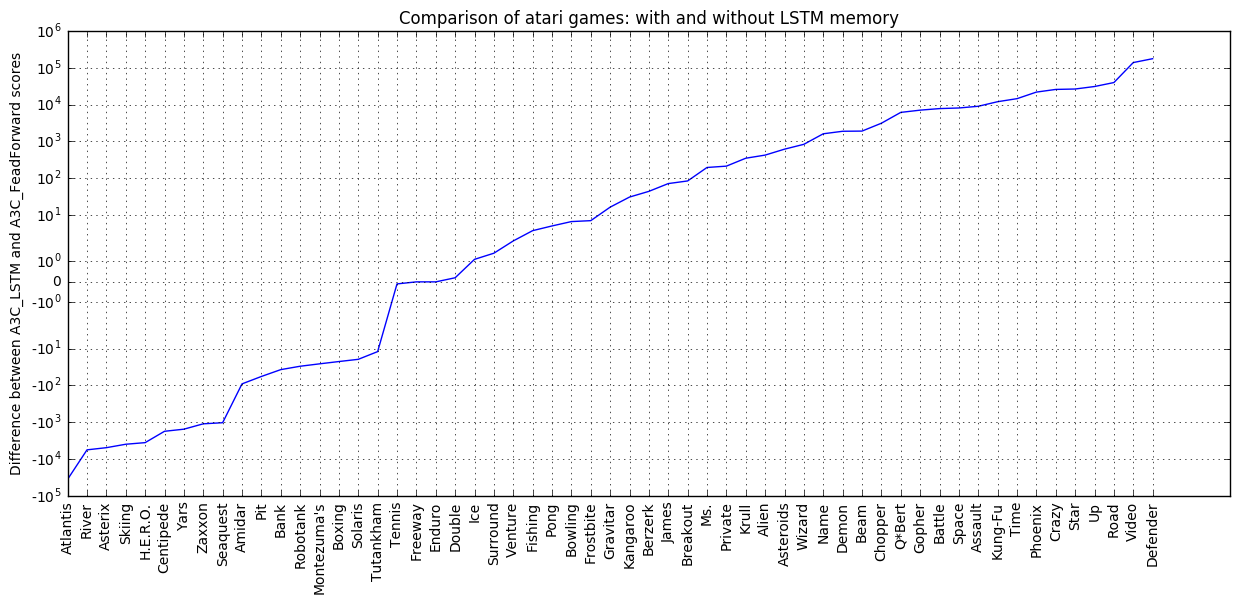

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(np.sort(score_difference))
plt.yscale("symlog")
plt.xticks(np.arange(len(game_names)), np.array(
    game_names)[idxs], rotation='vertical')
plt.grid()
plt.title("Comparison A3C on atari games: with and without LSTM memory")
plt.ylabel("Difference between A3C_LSTM and A3C_FeadForward scores")